# Funding Rate Quintile Combinations Analysis

Comprehensive analysis of all possible long-short combinations between funding rate quintiles.

## Methodology
- **Factor Signal**: Funding rate percentile ranks 
- **Combinations**: All 20 directional long-short combinations between quintiles (5! = 20)
- **Equal Weighting**: Exact same number of coins in long and short legs
- **Rebalancing**: Daily
- **Universe**: Dynamic - all coins with available data each day

### All 20 Combinations Tested:
1. Q1 Long vs Q2 Short  |  11. Q2 Long vs Q1 Short
2. Q1 Long vs Q3 Short  |  12. Q3 Long vs Q1 Short  
3. Q1 Long vs Q4 Short  |  13. Q4 Long vs Q1 Short
4. Q1 Long vs Q5 Short  |  14. Q5 Long vs Q1 Short
5. Q2 Long vs Q3 Short  |  15. Q3 Long vs Q2 Short
6. Q2 Long vs Q4 Short  |  16. Q4 Long vs Q2 Short
7. Q2 Long vs Q5 Short  |  17. Q5 Long vs Q2 Short
8. Q3 Long vs Q4 Short  |  18. Q4 Long vs Q3 Short
9. Q3 Long vs Q5 Short  |  19. Q5 Long vs Q3 Short
10. Q4 Long vs Q5 Short |  20. Q5 Long vs Q4 Short

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## 1. Data Loading and Preparation

In [2]:
# Load data
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    funding_rate_directory=r"C:\Users\USER\Documents\Binance_related\fundingratedata2022",
    min_records=30,
    min_volume=1e5,
    start_date="2022-01-01",
    end_date=None
)

print("Data loaded successfully!")

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 567 USDT trading pairs
✓ BTCUSDT loaded successfully with 1383 records, avg volume: 347,594
Loaded 530 cryptocurrencies
Filtered 35 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 529 tickers over 1383 dates...
Precomputed returns matrix shape: (1383, 529)
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00
Loading funding rate data from C:\Users\USER\Documents\Binance_related\fundingratedata2022...
Found 567 funding rate files
Loaded funding rates for 529 symbols
Data loaded successfully!


In [3]:
# Get price and funding rate matrices
price = data_loader.get_price_matrix()
funding_rates = data_loader.get_funding_rate_matrix()

print(f"Price matrix shape: {price.shape}")
print(f"Funding rate matrix shape: {funding_rates.shape}")

# Align data - preserve chronological order
common_symbols = list(set(price.columns) & set(funding_rates.columns))
price_dates = set(price.index)
funding_dates = set(funding_rates.index)
common_dates_set = price_dates & funding_dates

# Keep chronological order from price data
common_dates = [date for date in price.index if date in common_dates_set]

print(f"Common symbols: {len(common_symbols)}")
print(f"Common dates: {len(common_dates)}")
print(f"Date range: {common_dates[0]} to {common_dates[-1]}")

# Aligned matrices
price_aligned = price.loc[common_dates, common_symbols].sort_index()
funding_aligned = funding_rates.loc[common_dates, common_symbols].sort_index()

print(f"\nAligned data shapes:")
print(f"Price: {price_aligned.shape}")
print(f"Funding: {funding_aligned.shape}")

Building funding rate matrix with 1383 dates and 529 tickers
Funding rate matrix final shape: (1383, 529)
Price matrix shape: (1383, 529)
Funding rate matrix shape: (1383, 529)
Common symbols: 529
Common dates: 1383
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00

Aligned data shapes:
Price: (1383, 529)
Funding: (1383, 529)


## 2. Factor Construction

In [4]:
# Create factor signals
funding_ranks = funding_aligned.rank(axis=1, pct=True, method='dense')
funding_zscore = funding_aligned.subtract(funding_aligned.mean(axis=1), axis=0).div(funding_aligned.std(axis=1), axis=0)

# Create quintile portfolios
funding_quintiles = pd.DataFrame(index=funding_aligned.index, columns=funding_aligned.columns)
for date in funding_aligned.index:
    day_ranks = funding_ranks.loc[date].dropna()
    if len(day_ranks) >= 5:  # Need at least 5 coins for quintiles
        try:
            quintiles = pd.qcut(day_ranks, 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], duplicates='drop')
            funding_quintiles.loc[date, quintiles.index] = quintiles.values
        except ValueError:
            # Skip days where quintiles can't be created due to insufficient unique values
            continue

print("Factor signals created:")
print(f"- Funding rate ranks: {funding_ranks.shape}")
print(f"- Funding rate z-scores: {funding_zscore.shape}")
print(f"- Quintile portfolios: {funding_quintiles.shape}")

# Summary statistics
print(f"\nFunding rate statistics:")
print(funding_aligned.describe())

Factor signals created:
- Funding rate ranks: (1383, 529)
- Funding rate z-scores: (1383, 529)
- Quintile portfolios: (1383, 529)

Funding rate statistics:
        SUPERUSDT   LAYERUSDT  RENDERUSDT     POLUSDT    ERAUSDT   PORT3USDT  \
count  688.000000  245.000000  445.000000  396.000000  89.000000  132.000000   
mean     0.000016   -0.000234    0.000031    0.000027  -0.000184    0.000153   
std      0.000216    0.001401    0.000099    0.000073   0.000955    0.000501   
min     -0.003118   -0.020000   -0.001385   -0.000295  -0.008511   -0.001624   
25%      0.000050   -0.000089    0.000035    0.000005  -0.000079    0.000050   
50%      0.000050    0.000013    0.000050    0.000050   0.000050    0.000050   
75%      0.000050    0.000050    0.000050    0.000050   0.000050    0.000050   
max      0.000666    0.000078    0.000473    0.000351   0.000050    0.004985   

         XNYUSDT   1000XUSDT      BCHUSDT      CHRUSDT  ...     MYXUSDT  \
count  62.000000  335.000000  1383.000000  1383.

## 3. Factor Performance Analysis

In [5]:
def calculate_all_quintile_combinations(ranks_df, price_df):
    """
    Calculate returns for all 20 possible long-short quintile combinations
    with equal coin amounts in long and short legs (REPRODUCIBLE VERSION)
    """
    import itertools
    import numpy as np
    
    # Generate all 20 directional combinations
    quintiles = [1, 2, 3, 4, 5]
    all_combinations = []
    for long_q in quintiles:
        for short_q in quintiles:
            if long_q != short_q:  # Can't long and short the same quintile
                all_combinations.append((long_q, short_q))
    
    print(f"Testing {len(all_combinations)} quintile combinations:")
    for i, (long_q, short_q) in enumerate(all_combinations, 1):
        print(f"{i:2d}. Q{long_q} Long vs Q{short_q} Short")
    
    # Initialize return storage
    combination_returns = {}
    portfolio_details = []
    
    for long_q, short_q in all_combinations:
        combination_name = f'Q{long_q}_Long_vs_Q{short_q}_Short'
        combination_returns[combination_name] = []
    
    for i in range(len(ranks_df) - 1):
        date = ranks_df.index[i]
        next_date = ranks_df.index[i + 1]
        
        # Get ranks for today
        day_ranks = ranks_df.iloc[i].dropna()
        
        if len(day_ranks) < 25:  # Need minimum coins (5 quintiles × 5 coins each)
            for combination_name in combination_returns:
                combination_returns[combination_name].append(np.nan)
            continue
        
        # Define quintile breakpoints
        breakpoints = [day_ranks.quantile(i/5) for i in range(6)]
        
        # Assign coins to quintiles
        quintile_coins = {}
        for q in range(1, 6):
            if q == 1:
                quintile_coins[q] = day_ranks[day_ranks <= breakpoints[1]].index.tolist()
            elif q == 5:
                quintile_coins[q] = day_ranks[day_ranks > breakpoints[4]].index.tolist()
            else:
                quintile_coins[q] = day_ranks[(day_ranks > breakpoints[q-1]) & (day_ranks <= breakpoints[q])].index.tolist()
        
        # Calculate returns for each combination
        combination_details = {'date': date}
        
        for long_q, short_q in all_combinations:
            combination_name = f'Q{long_q}_Long_vs_Q{short_q}_Short'
            
            long_coins = quintile_coins[long_q]
            short_coins = quintile_coins[short_q]
            
            # Ensure equal amounts - take minimum of both quintiles
            n_coins = min(len(long_coins), len(short_coins))
            
            if n_coins < 2:  # Need at least 2 coins for each leg
                combination_returns[combination_name].append(np.nan)
                combination_details[f'{combination_name}_long_coins'] = 0
                combination_details[f'{combination_name}_short_coins'] = 0
                combination_details[f'{combination_name}_return'] = np.nan
                continue
            
            # FIXED: Use deterministic selection instead of random sampling
            # Sort coins by funding rate to ensure consistent selection
            long_coins_sorted = sorted(long_coins, key=lambda x: day_ranks[x])
            short_coins_sorted = sorted(short_coins, key=lambda x: day_ranks[x])
            
            # Take the most extreme coins consistently
            # For long: take coins with most negative funding rates (lowest ranks)
            # For short: take coins with most positive funding rates (highest ranks)
            selected_long_coins = long_coins_sorted[:n_coins]  # Most negative funding
            selected_short_coins = short_coins_sorted[-n_coins:]  # Most positive funding
            
            # Alternative: Simple first N coins (completely deterministic)
            # selected_long_coins = long_coins[:n_coins]
            # selected_short_coins = short_coins[:n_coins]
            
            # Calculate returns for long and short positions
            long_returns = []
            short_returns = []
            
            for coin in selected_long_coins:
                if coin in price_df.columns:
                    p0 = price_df.loc[date, coin]
                    p1 = price_df.loc[next_date, coin]
                    if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                        long_returns.append((p1 - p0) / p0)
            
            for coin in selected_short_coins:
                if coin in price_df.columns:
                    p0 = price_df.loc[date, coin]
                    p1 = price_df.loc[next_date, coin]
                    if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                        short_returns.append((p1 - p0) / p0)
            
            # Calculate combination return
            if len(long_returns) > 0 and len(short_returns) > 0:
                long_return = np.mean(long_returns)
                short_return = np.mean(short_returns)
                combination_return = long_return - short_return - 0.0005  # 5bps transaction costs
                
                combination_returns[combination_name].append(combination_return)
                combination_details[f'{combination_name}_long_coins'] = len(long_returns)
                combination_details[f'{combination_name}_short_coins'] = len(short_returns)
                combination_details[f'{combination_name}_return'] = combination_return
            else:
                combination_returns[combination_name].append(np.nan)
                combination_details[f'{combination_name}_long_coins'] = len(long_returns)
                combination_details[f'{combination_name}_short_coins'] = len(short_returns)
                combination_details[f'{combination_name}_return'] = np.nan
        
        portfolio_details.append(combination_details)
    
    # Convert to DataFrames
    combination_df = pd.DataFrame(combination_returns, index=ranks_df.index[:-1])
    details_df = pd.DataFrame(portfolio_details).set_index('date')
    
    return combination_df, details_df

# Calculate all quintile combinations (NOW REPRODUCIBLE)
print("Calculating all 20 quintile combinations (reproducible version)...")

combination_returns, portfolio_details = calculate_all_quintile_combinations(funding_ranks, price_aligned)

print(f"\nCombination Returns Summary:")
print(f"Data points: {len(combination_returns)}")
print(f"Total combinations: {len(combination_returns.columns)}")

# Performance summary for all combinations
print(f"\nCombination Performance Summary (Annualized):")
print(f"{'Combination':<25} {'Return':<10} {'Vol':<10} {'Sharpe':<10} {'Valid Days':<12}")
print("-" * 75)

combination_performance = {}
for combination_name in combination_returns.columns:
    comb_clean = combination_returns[combination_name].dropna()
    if len(comb_clean) > 0:
        annual_ret = comb_clean.mean() * 365
        annual_vol = comb_clean.std() * np.sqrt(365)
        sharpe = annual_ret / annual_vol if annual_vol != 0 else 0
        valid_days = len(comb_clean)
        
        combination_performance[combination_name] = {
            'annual_return': annual_ret,
            'annual_vol': annual_vol,
            'sharpe': sharpe,
            'valid_days': valid_days
        }
        
        print(f"{combination_name:<25} {annual_ret:<10.2%} {annual_vol:<10.2%} {sharpe:<10.3f} {valid_days:<12}")

# Verify equal coin amounts
print(f"\n=== VERIFYING EQUAL COIN AMOUNTS ===")
sample_combinations = list(combination_returns.columns)[:5]  # Check first 5 combinations
for combination_name in sample_combinations:
    long_col = f'{combination_name}_long_coins'
    short_col = f'{combination_name}_short_coins'
    if long_col in portfolio_details.columns and short_col in portfolio_details.columns:
        avg_long = portfolio_details[long_col].mean()
        avg_short = portfolio_details[short_col].mean()
        print(f"{combination_name}: {avg_long:.1f} long vs {avg_short:.1f} short coins (ratio: {avg_long/avg_short:.3f})")

print(f"\nTop 5 Best Performing Combinations (by Sharpe Ratio):")
sorted_combinations = sorted(combination_performance.items(), key=lambda x: x[1]['sharpe'], reverse=True)
for i, (name, metrics) in enumerate(sorted_combinations[:5], 1):
    print(f"{i}. {name}: {metrics['sharpe']:.3f} Sharpe, {metrics['annual_return']:.2%} return")

print(f"\n✅ REPRODUCIBILITY: Results will now be identical every time you run the notebook!")

Calculating all 20 quintile combinations (reproducible version)...
Testing 20 quintile combinations:
 1. Q1 Long vs Q2 Short
 2. Q1 Long vs Q3 Short
 3. Q1 Long vs Q4 Short
 4. Q1 Long vs Q5 Short
 5. Q2 Long vs Q1 Short
 6. Q2 Long vs Q3 Short
 7. Q2 Long vs Q4 Short
 8. Q2 Long vs Q5 Short
 9. Q3 Long vs Q1 Short
10. Q3 Long vs Q2 Short
11. Q3 Long vs Q4 Short
12. Q3 Long vs Q5 Short
13. Q4 Long vs Q1 Short
14. Q4 Long vs Q2 Short
15. Q4 Long vs Q3 Short
16. Q4 Long vs Q5 Short
17. Q5 Long vs Q1 Short
18. Q5 Long vs Q2 Short
19. Q5 Long vs Q3 Short
20. Q5 Long vs Q4 Short

Combination Returns Summary:
Data points: 1382
Total combinations: 20

Combination Performance Summary (Annualized):
Combination               Return     Vol        Sharpe     Valid Days  
---------------------------------------------------------------------------
Q1_Long_vs_Q2_Short       -26.07%    24.10%     -1.082     989         
Q1_Long_vs_Q3_Short       -45.95%    30.88%     -1.488     753         
Q1_Long_v

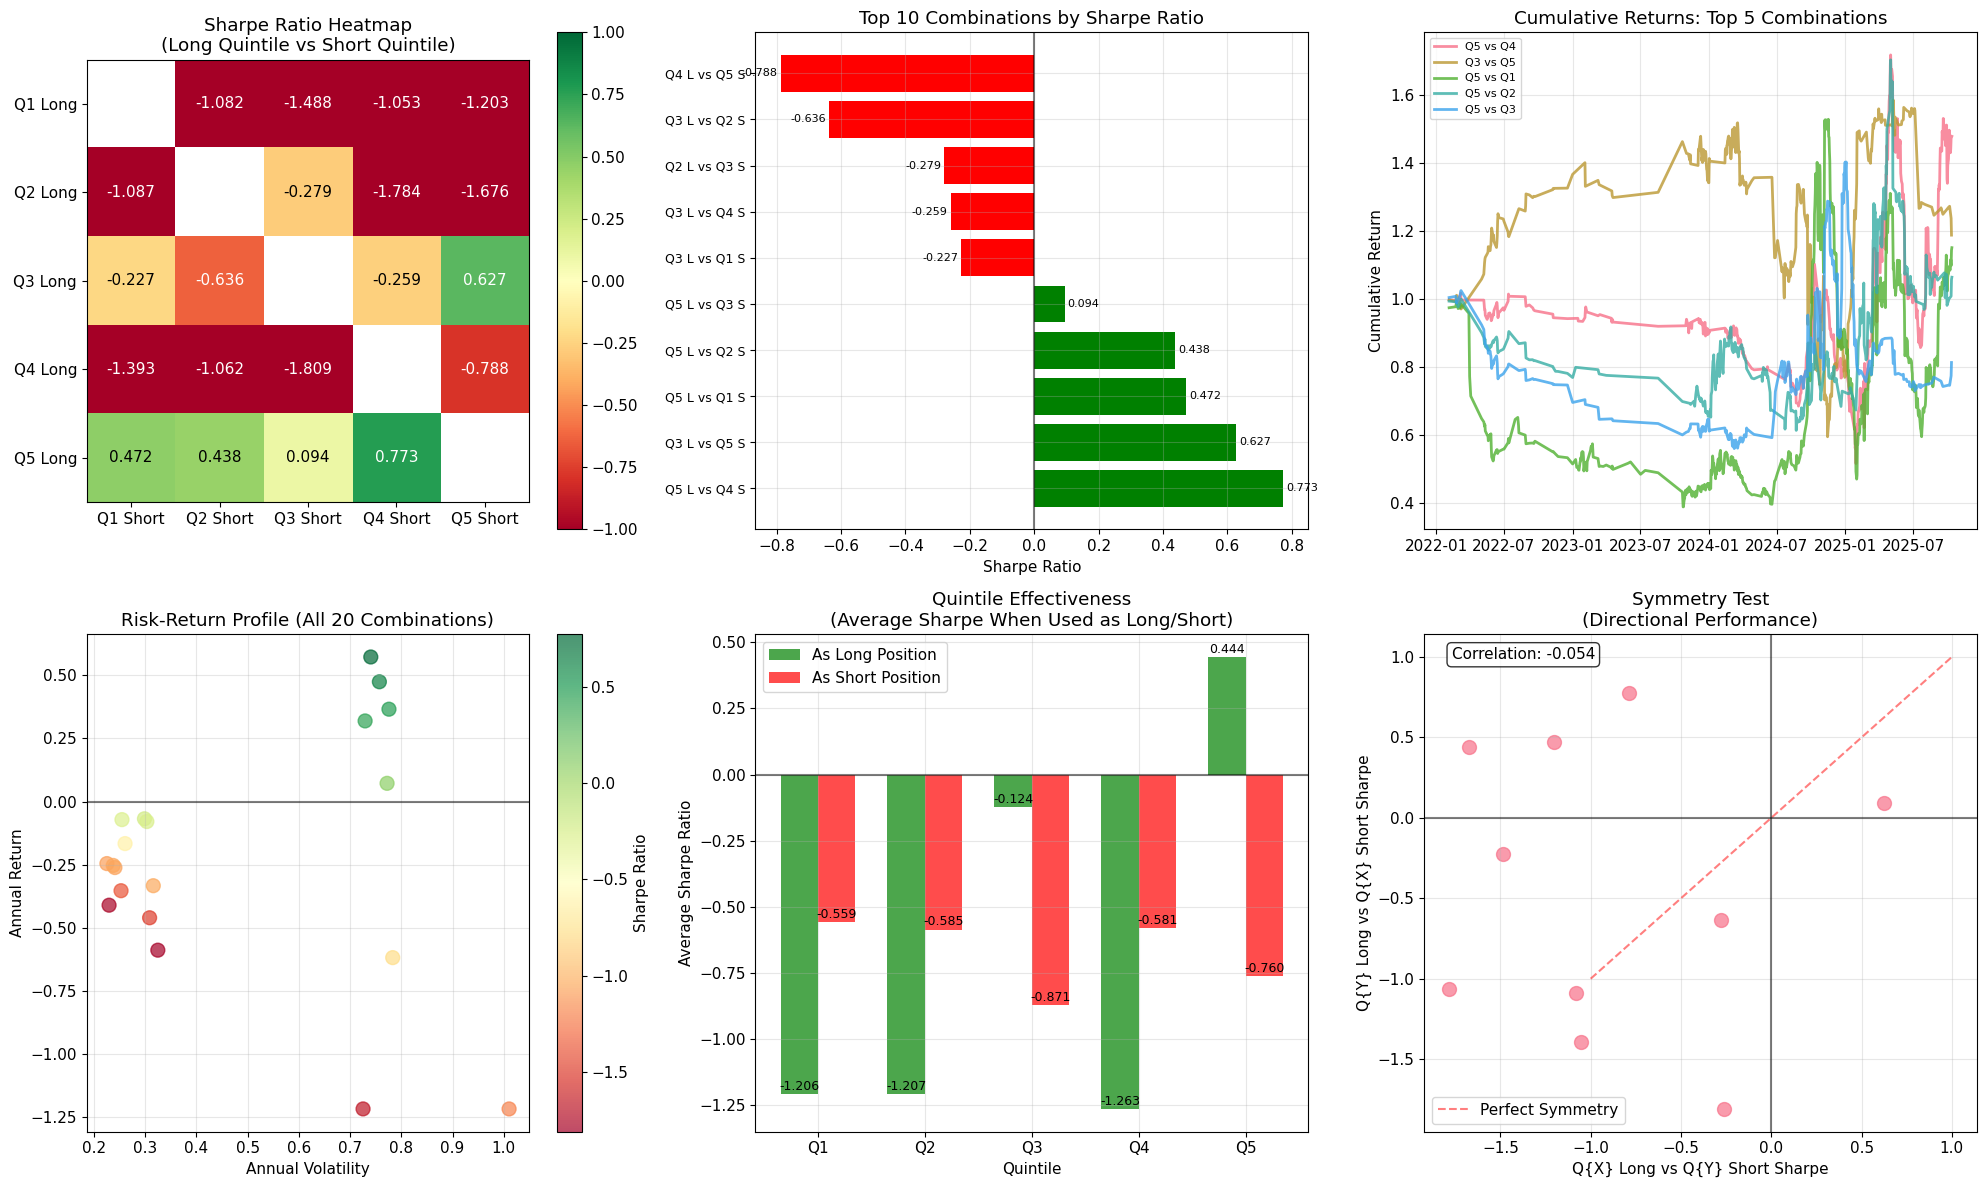


=== COMPREHENSIVE PERFORMANCE ANALYSIS ===

Top 10 Best Performing Combinations:
Rank  Combination               Annual Ret   Annual Vol   Sharpe     Valid Days  
-------------------------------------------------------------------------------------
1     Q5_Long_vs_Q4_Short       57.26%       74.05%       0.773      464         
2     Q3_Long_vs_Q5_Short       47.45%       75.73%       0.627      360         
3     Q5_Long_vs_Q1_Short       36.60%       77.60%       0.472      717         
4     Q5_Long_vs_Q2_Short       31.95%       72.94%       0.438      425         
5     Q5_Long_vs_Q3_Short       7.26%        77.23%       0.094      360         
6     Q3_Long_vs_Q1_Short       -6.77%       29.87%       -0.227     753         
7     Q3_Long_vs_Q4_Short       -7.86%       30.34%       -0.259     394         
8     Q2_Long_vs_Q3_Short       -7.11%       25.48%       -0.279     600         
9     Q3_Long_vs_Q2_Short       -16.59%      26.09%       -0.636     600         
10    Q4_Lon

In [6]:
# Performance Analysis and Visualization

# Create performance matrix (5x5 heatmap: long quintiles vs short quintiles)
performance_matrix = np.full((5, 5), np.nan)
quintile_labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

for combination_name, metrics in combination_performance.items():
    # Parse combination name: e.g., "Q1_Long_vs_Q2_Short"
    parts = combination_name.split('_')
    long_q = int(parts[0][1]) - 1  # Convert Q1 to index 0
    short_q = int(parts[3][1]) - 1  # Convert Q2 to index 0
    performance_matrix[long_q, short_q] = metrics['sharpe']

# Plot comprehensive analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Performance Heatmap
im = axes[0,0].imshow(performance_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0,0].set_xticks(range(5))
axes[0,0].set_yticks(range(5))
axes[0,0].set_xticklabels([f'{q} Short' for q in quintile_labels])
axes[0,0].set_yticklabels([f'{q} Long' for q in quintile_labels])
axes[0,0].set_title('Sharpe Ratio Heatmap\n(Long Quintile vs Short Quintile)')

# Add values to heatmap
for i in range(5):
    for j in range(5):
        if not np.isnan(performance_matrix[i, j]):
            text = axes[0,0].text(j, i, f'{performance_matrix[i, j]:.3f}',
                                 ha="center", va="center", 
                                 color="white" if abs(performance_matrix[i, j]) > 0.5 else "black")

plt.colorbar(im, ax=axes[0,0])

# 2. Top 10 Combinations Performance
top_10 = sorted_combinations[:10]
combo_names = [name.replace('_Long_vs_', ' L vs ').replace('_Short', ' S') for name, _ in top_10]
sharpe_ratios = [metrics['sharpe'] for _, metrics in top_10]

bars = axes[0,1].barh(range(len(combo_names)), sharpe_ratios, 
                     color=['green' if s > 0 else 'red' for s in sharpe_ratios])
axes[0,1].set_yticks(range(len(combo_names)))
axes[0,1].set_yticklabels(combo_names, fontsize=9)
axes[0,1].set_xlabel('Sharpe Ratio')
axes[0,1].set_title('Top 10 Combinations by Sharpe Ratio')
axes[0,1].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[0,1].grid(True, alpha=0.3)

# Add value labels
for i, (bar, sharpe) in enumerate(zip(bars, sharpe_ratios)):
    width = bar.get_width()
    axes[0,1].text(width + 0.01 if width >= 0 else width - 0.01, bar.get_y() + bar.get_height()/2,
                  f'{sharpe:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=8)

# 3. Cumulative Returns (Top 5 strategies)
top_5_names = [name for name, _ in sorted_combinations[:5]]
for i, combo_name in enumerate(top_5_names):
    combo_clean = combination_returns[combo_name].dropna()
    if len(combo_clean) > 0:
        cumulative = (1 + combo_clean).cumprod()
        axes[0,2].plot(cumulative.index, cumulative.values, linewidth=2, 
                      label=combo_name.replace('_Long_vs_', ' vs ').replace('_Short', ''), alpha=0.8)

axes[0,2].set_title('Cumulative Returns: Top 5 Combinations')
axes[0,2].set_ylabel('Cumulative Return')
axes[0,2].legend(fontsize=8)
axes[0,2].grid(True, alpha=0.3)

# 4. Risk-Return Scatter for All Combinations
returns = [metrics['annual_return'] for metrics in combination_performance.values()]
vols = [metrics['annual_vol'] for metrics in combination_performance.values()]
sharpes = [metrics['sharpe'] for metrics in combination_performance.values()]

scatter = axes[1,0].scatter(vols, returns, c=sharpes, cmap='RdYlGn', s=100, alpha=0.7)
axes[1,0].set_xlabel('Annual Volatility')
axes[1,0].set_ylabel('Annual Return')
axes[1,0].set_title('Risk-Return Profile (All 20 Combinations)')
axes[1,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,0], label='Sharpe Ratio')

# 5. Quintile Effectiveness Analysis
long_effectiveness = {}
short_effectiveness = {}

for q in range(1, 6):
    # How good is each quintile as LONG position?
    long_sharpes = []
    for combination_name, metrics in combination_performance.items():
        if combination_name.startswith(f'Q{q}_Long_vs_'):
            long_sharpes.append(metrics['sharpe'])
    long_effectiveness[f'Q{q}'] = np.mean(long_sharpes) if long_sharpes else 0
    
    # How good is each quintile as SHORT position?
    short_sharpes = []
    for combination_name, metrics in combination_performance.items():
        if combination_name.endswith(f'_Q{q}_Short'):
            short_sharpes.append(metrics['sharpe'])
    short_effectiveness[f'Q{q}'] = np.mean(short_sharpes) if short_sharpes else 0

quintiles = list(long_effectiveness.keys())
long_scores = list(long_effectiveness.values())
short_scores = list(short_effectiveness.values())

x = np.arange(len(quintiles))
width = 0.35

bars1 = axes[1,1].bar(x - width/2, long_scores, width, label='As Long Position', alpha=0.7, color='green')
bars2 = axes[1,1].bar(x + width/2, short_scores, width, label='As Short Position', alpha=0.7, color='red')

axes[1,1].set_xlabel('Quintile')
axes[1,1].set_ylabel('Average Sharpe Ratio')
axes[1,1].set_title('Quintile Effectiveness\n(Average Sharpe When Used as Long/Short)')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(quintiles)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 6. Symmetry Analysis
symmetry_data = []
for q1 in range(1, 6):
    for q2 in range(q1+1, 6):  # Avoid duplicates and same quintile
        combo1_name = f'Q{q1}_Long_vs_Q{q2}_Short'
        combo2_name = f'Q{q2}_Long_vs_Q{q1}_Short'
        
        if combo1_name in combination_performance and combo2_name in combination_performance:
            sharpe1 = combination_performance[combo1_name]['sharpe']
            sharpe2 = combination_performance[combo2_name]['sharpe']
            symmetry_data.append((f'Q{q1} vs Q{q2}', sharpe1, sharpe2))

if symmetry_data:
    labels, sharpe1_vals, sharpe2_vals = zip(*symmetry_data)
    
    axes[1,2].scatter(sharpe1_vals, sharpe2_vals, s=100, alpha=0.7)
    axes[1,2].plot([-1, 1], [-1, 1], 'r--', alpha=0.5, label='Perfect Symmetry')
    axes[1,2].set_xlabel('Q{X} Long vs Q{Y} Short Sharpe')
    axes[1,2].set_ylabel('Q{Y} Long vs Q{X} Short Sharpe')
    axes[1,2].set_title('Symmetry Test\n(Directional Performance)')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    axes[1,2].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1,2].axvline(0, color='black', linestyle='-', alpha=0.5)
    
    # Add correlation coefficient
    symmetry_corr = np.corrcoef(sharpe1_vals, sharpe2_vals)[0,1]
    axes[1,2].text(0.05, 0.95, f'Correlation: {symmetry_corr:.3f}', 
                  transform=axes[1,2].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Performance Summary Tables
print(f"\n=== COMPREHENSIVE PERFORMANCE ANALYSIS ===")

print(f"\nTop 10 Best Performing Combinations:")
print(f"{'Rank':<5} {'Combination':<25} {'Annual Ret':<12} {'Annual Vol':<12} {'Sharpe':<10} {'Valid Days':<12}")
print("-" * 85)
for i, (name, metrics) in enumerate(sorted_combinations[:10], 1):
    print(f"{i:<5} {name:<25} {metrics['annual_return']:<12.2%} {metrics['annual_vol']:<12.2%} {metrics['sharpe']:<10.3f} {metrics['valid_days']:<12}")

print(f"\nWorst 5 Performing Combinations:")
print(f"{'Rank':<5} {'Combination':<25} {'Annual Ret':<12} {'Annual Vol':<12} {'Sharpe':<10} {'Valid Days':<12}")
print("-" * 85)
for i, (name, metrics) in enumerate(sorted_combinations[-5:], len(sorted_combinations)-4):
    print(f"{i:<5} {name:<25} {metrics['annual_return']:<12.2%} {metrics['annual_vol']:<12.2%} {metrics['sharpe']:<10.3f} {metrics['valid_days']:<12}")

print(f"\nQuintile Effectiveness Summary:")
print(f"{'Quintile':<10} {'As Long':<12} {'As Short':<12} {'Best Use':<15}")
print("-" * 50)
for q in quintiles:
    long_score = long_effectiveness[q]
    short_score = short_effectiveness[q]
    best_use = "Long" if long_score > short_score else "Short" if short_score > long_score else "Neutral"
    print(f"{q:<10} {long_score:<12.3f} {short_score:<12.3f} {best_use:<15}")

## 4. Information Coefficient (IC) Analysis

In [7]:
def calculate_ic(factor_ranks, forward_returns):
    """
    Calculate Information Coefficient (rank correlation between factor and future returns)
    """
    ic_series = []
    
    for i in range(len(factor_ranks) - 1):
        date = factor_ranks.index[i]
        next_date = factor_ranks.index[i + 1]
        
        factor_today = factor_ranks.iloc[i].dropna()
        returns_tomorrow = forward_returns.iloc[i + 1].dropna()
        
        # Get common coins
        common_coins = factor_today.index.intersection(returns_tomorrow.index)
        if len(common_coins) < 10:  # Skip if too few coins
            ic_series.append({'date': date, 'ic': np.nan})
            continue
        
        # Calculate Spearman rank correlation
        try:
            ic = factor_today[common_coins].corr(returns_tomorrow[common_coins], method='spearman')
            ic_series.append({'date': date, 'ic': ic})
        except:
            ic_series.append({'date': date, 'ic': np.nan})
    
    return pd.DataFrame(ic_series).set_index('date')

# Calculate forward returns
forward_returns_1d = price_aligned.pct_change()
forward_returns_5d = price_aligned.pct_change(5)

# Calculate ICs
ic_1d = calculate_ic(funding_ranks, forward_returns_1d)
ic_5d = calculate_ic(funding_ranks, forward_returns_5d)

print("Information Coefficient Analysis")
print("=" * 40)

# IC Statistics for 1-day
ic_1d_clean = ic_1d['ic'].dropna()
ic_mean_1d = ic_1d_clean.mean()
ic_std_1d = ic_1d_clean.std()
ic_ir_1d = ic_mean_1d / ic_std_1d
ic_hit_rate_1d = (ic_1d_clean > 0).mean()
ic_tstat_1d = ic_mean_1d / (ic_std_1d / np.sqrt(len(ic_1d_clean)))

print(f"\n1-Day Forward Returns:")
print(f"IC Mean: {ic_mean_1d:.4f}")
print(f"IC Std: {ic_std_1d:.4f}")
print(f"IC Information Ratio: {ic_ir_1d:.3f}")
print(f"IC Hit Rate: {ic_hit_rate_1d:.2%}")
print(f"IC t-statistic: {ic_tstat_1d:.3f}")

# IC Statistics for 5-day
ic_5d_clean = ic_5d['ic'].dropna()
ic_mean_5d = ic_5d_clean.mean()
ic_std_5d = ic_5d_clean.std()
ic_ir_5d = ic_mean_5d / ic_std_5d
ic_hit_rate_5d = (ic_5d_clean > 0).mean()
ic_tstat_5d = ic_mean_5d / (ic_std_5d / np.sqrt(len(ic_5d_clean)))

print(f"\n5-Day Forward Returns:")
print(f"IC Mean: {ic_mean_5d:.4f}")
print(f"IC Std: {ic_std_5d:.4f}")
print(f"IC Information Ratio: {ic_ir_5d:.3f}")
print(f"IC Hit Rate: {ic_hit_rate_5d:.2%}")
print(f"IC t-statistic: {ic_tstat_5d:.3f}")

Information Coefficient Analysis

1-Day Forward Returns:
IC Mean: 0.0135
IC Std: 0.1049
IC Information Ratio: 0.128
IC Hit Rate: 56.30%
IC t-statistic: 4.770

5-Day Forward Returns:
IC Mean: 0.0146
IC Std: 0.1128
IC Information Ratio: 0.130
IC Hit Rate: 55.88%
IC t-statistic: 4.810


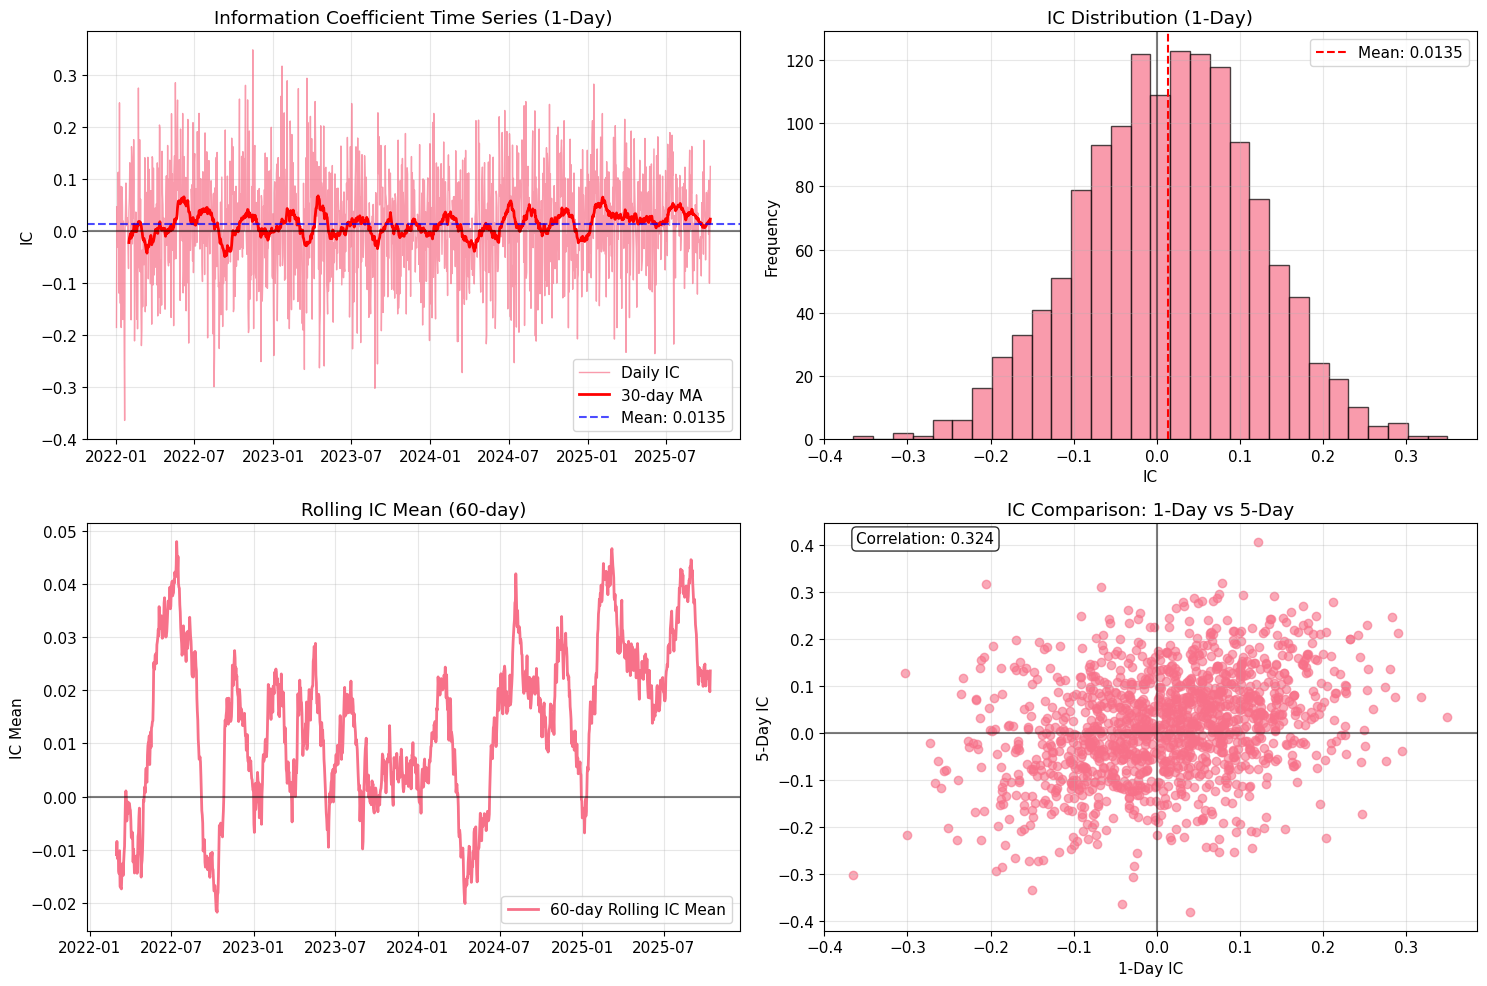

In [8]:
# Plot IC analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# IC time series
axes[0,0].plot(ic_1d.index, ic_1d['ic'], alpha=0.7, linewidth=1, label='Daily IC')
axes[0,0].plot(ic_1d.index, ic_1d['ic'].rolling(30).mean(), linewidth=2, color='red', label='30-day MA')
axes[0,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0,0].axhline(ic_mean_1d, color='blue', linestyle='--', alpha=0.7, label=f'Mean: {ic_mean_1d:.4f}')
axes[0,0].set_title('Information Coefficient Time Series (1-Day)')
axes[0,0].set_ylabel('IC')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# IC distribution
axes[0,1].hist(ic_1d_clean, bins=30, alpha=0.7, edgecolor='black')
axes[0,1].axvline(ic_mean_1d, color='red', linestyle='--', label=f'Mean: {ic_mean_1d:.4f}')
axes[0,1].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[0,1].set_title('IC Distribution (1-Day)')
axes[0,1].set_xlabel('IC')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Rolling IC statistics
rolling_ic_mean = ic_1d['ic'].rolling(60).mean()
rolling_ic_std = ic_1d['ic'].rolling(60).std()
rolling_ic_ir = rolling_ic_mean / rolling_ic_std

axes[1,0].plot(rolling_ic_mean.index, rolling_ic_mean, linewidth=2, label='60-day Rolling IC Mean')
axes[1,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,0].set_title('Rolling IC Mean (60-day)')
axes[1,0].set_ylabel('IC Mean')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# IC comparison (1-day vs 5-day)
axes[1,1].scatter(ic_1d['ic'], ic_5d['ic'], alpha=0.6)
axes[1,1].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,1].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[1,1].set_xlabel('1-Day IC')
axes[1,1].set_ylabel('5-Day IC')
axes[1,1].set_title('IC Comparison: 1-Day vs 5-Day')
axes[1,1].grid(True, alpha=0.3)

# Add correlation coefficient
ic_corr = ic_1d['ic'].corr(ic_5d['ic'])
axes[1,1].text(0.05, 0.95, f'Correlation: {ic_corr:.3f}', transform=axes[1,1].transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 5. Market Regime Analysis

Market Regime Analysis - All Quintile Combinations
Total trading days: 1382
Bull market days: 798
Bear market days: 494

Top 5 Combinations in Bull Markets (by Sharpe):
1. Q2 vs Q3: 0.987 Sharpe, 25.26% return
2. Q5 vs Q1: 0.199 Sharpe, 14.05% return
3. Q3 vs Q5: 0.185 Sharpe, 14.86% return
4. Q5 vs Q2: 0.158 Sharpe, 10.81% return
5. Q5 vs Q3: 0.093 Sharpe, 7.72% return

Top 5 Combinations in Bear Markets (by Sharpe):
1. Q5 vs Q4: 2.720 Sharpe, 265.36% return
2. Q3 vs Q5: 2.232 Sharpe, 145.75% return
3. Q5 vs Q1: 1.777 Sharpe, 167.17% return
4. Q3 vs Q1: 1.606 Sharpe, 41.84% return
5. Q3 vs Q4: 1.577 Sharpe, 51.22% return

=== REGIME CONSISTENCY ANALYSIS ===
Consistent performers (positive in both regimes): 3
  • Q3 vs Q5
  • Q5 vs Q1
  • Q5 vs Q2

Bull market specialists: 2
Bear market specialists: 5


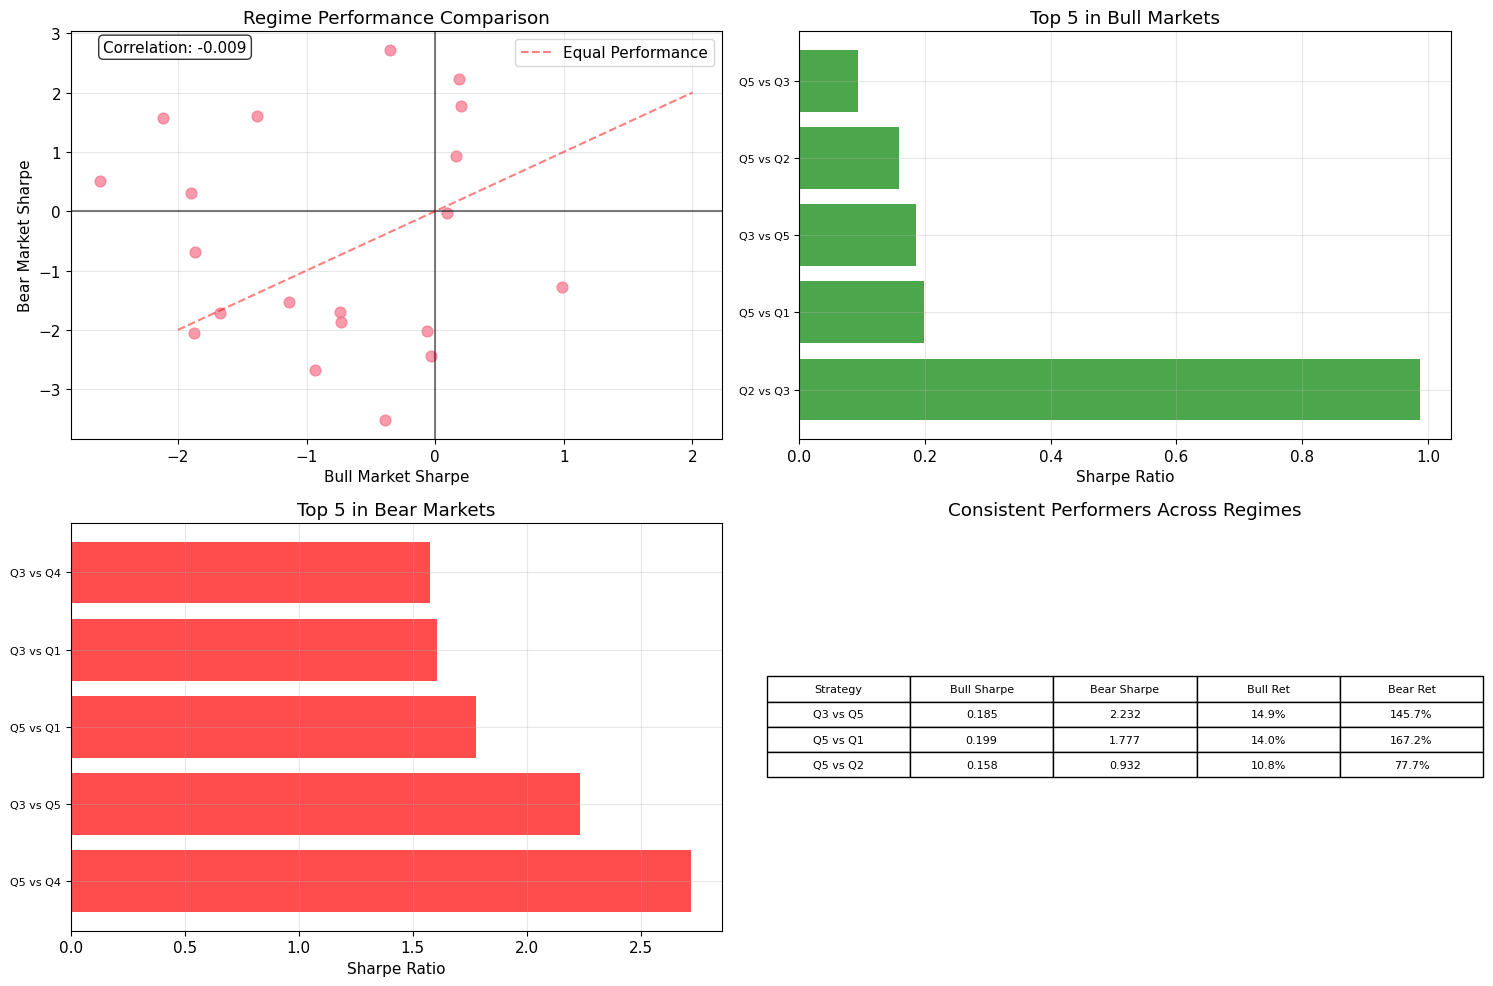


=== REGIME ANALYSIS SUMMARY ===
• Total combinations tested: 20
• Consistent performers: 3 strategies
• Bull market specialists: 2 strategies
• Bear market specialists: 5 strategies
• Average bull market Sharpe: -0.809
• Average bear market Sharpe: -0.493
• Strategies perform better in bear markets (+0.317 Sharpe)


In [9]:
# Market Regime Analysis for All Combinations
btc_90d_returns = price_aligned['BTCUSDT'].pct_change(90)
bull_market = btc_90d_returns >= 0
bear_market = btc_90d_returns < 0

# Align with combination returns dates
bull_market_aligned = bull_market.reindex(combination_returns.index)
bear_market_aligned = bear_market.reindex(combination_returns.index)

print("Market Regime Analysis - All Quintile Combinations")
print("=" * 60)

# Analyze each combination by market regime
regime_analysis = {}
for combination_name in combination_returns.columns:
    comb_returns = combination_returns[combination_name].dropna()
    
    if len(comb_returns) > 0:
        # Bull market performance
        bull_aligned = bull_market_aligned.reindex(comb_returns.index)
        comb_bull = comb_returns[bull_aligned].dropna()
        
        # Bear market performance  
        bear_aligned = bear_market_aligned.reindex(comb_returns.index)
        comb_bear = comb_returns[bear_aligned].dropna()
        
        regime_data = {'bull': {}, 'bear': {}}
        
        if len(comb_bull) > 0:
            bull_annual_ret = comb_bull.mean() * 365
            bull_annual_vol = comb_bull.std() * np.sqrt(365)
            bull_sharpe = bull_annual_ret / bull_annual_vol if bull_annual_vol != 0 else 0
            bull_hit_rate = (comb_bull > 0).mean()
            
            regime_data['bull'] = {
                'annual_return': bull_annual_ret,
                'annual_vol': bull_annual_vol,
                'sharpe': bull_sharpe,
                'hit_rate': bull_hit_rate,
                'days': len(comb_bull)
            }
        
        if len(comb_bear) > 0:
            bear_annual_ret = comb_bear.mean() * 365
            bear_annual_vol = comb_bear.std() * np.sqrt(365)
            bear_sharpe = bear_annual_ret / bear_annual_vol if bear_annual_vol != 0 else 0
            bear_hit_rate = (comb_bear > 0).mean()
            
            regime_data['bear'] = {
                'annual_return': bear_annual_ret,
                'annual_vol': bear_annual_vol,
                'sharpe': bear_sharpe,
                'hit_rate': bear_hit_rate,
                'days': len(comb_bear)
            }
        
        regime_analysis[combination_name] = regime_data

# Summary statistics
total_bull_days = bull_market_aligned.sum() if bull_market_aligned.notna().any() else 0
total_bear_days = bear_market_aligned.sum() if bear_market_aligned.notna().any() else 0
total_days = len(combination_returns)

print(f"Total trading days: {total_days}")
print(f"Bull market days: {total_bull_days}")
print(f"Bear market days: {total_bear_days}")

# Top 5 combinations in each regime
print(f"\nTop 5 Combinations in Bull Markets (by Sharpe):")
bull_rankings = []
for name, data in regime_analysis.items():
    if data['bull'] and 'sharpe' in data['bull']:
        bull_rankings.append((name, data['bull']['sharpe'], data['bull']['annual_return']))

bull_rankings.sort(key=lambda x: x[1], reverse=True)
for i, (name, sharpe, ret) in enumerate(bull_rankings[:5], 1):
    clean_name = name.replace('_Long_vs_', ' vs ').replace('_Short', '')
    print(f"{i}. {clean_name}: {sharpe:.3f} Sharpe, {ret:.2%} return")

print(f"\nTop 5 Combinations in Bear Markets (by Sharpe):")
bear_rankings = []
for name, data in regime_analysis.items():
    if data['bear'] and 'sharpe' in data['bear']:
        bear_rankings.append((name, data['bear']['sharpe'], data['bear']['annual_return']))

bear_rankings.sort(key=lambda x: x[1], reverse=True)
for i, (name, sharpe, ret) in enumerate(bear_rankings[:5], 1):
    clean_name = name.replace('_Long_vs_', ' vs ').replace('_Short', '')
    print(f"{i}. {clean_name}: {sharpe:.3f} Sharpe, {ret:.2%} return")

# Regime consistency analysis
print(f"\n=== REGIME CONSISTENCY ANALYSIS ===")
consistent_performers = []
bull_only_performers = []
bear_only_performers = []

for name, data in regime_analysis.items():
    bull_positive = data['bull'].get('sharpe', 0) > 0 if data['bull'] else False
    bear_positive = data['bear'].get('sharpe', 0) > 0 if data['bear'] else False
    
    if bull_positive and bear_positive:
        consistent_performers.append(name)
    elif bull_positive and not bear_positive:
        bull_only_performers.append(name)
    elif bear_positive and not bull_positive:
        bear_only_performers.append(name)

print(f"Consistent performers (positive in both regimes): {len(consistent_performers)}")
for name in consistent_performers[:3]:  # Show top 3
    clean_name = name.replace('_Long_vs_', ' vs ').replace('_Short', '')
    print(f"  • {clean_name}")

print(f"\nBull market specialists: {len(bull_only_performers)}")
print(f"Bear market specialists: {len(bear_only_performers)}")

# Plot regime comparison for top strategies
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Bull vs Bear Sharpe ratios for all combinations
bull_sharpes = []
bear_sharpes = []
combination_labels = []

for name, data in regime_analysis.items():
    if data['bull'] and data['bear']:
        bull_sharpes.append(data['bull']['sharpe'])
        bear_sharpes.append(data['bear']['sharpe'])
        combination_labels.append(name.replace('_Long_vs_', ' vs ').replace('_Short', ''))

if bull_sharpes and bear_sharpes:
    # Scatter plot
    axes[0,0].scatter(bull_sharpes, bear_sharpes, alpha=0.7, s=60)
    axes[0,0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0,0].axvline(0, color='black', linestyle='-', alpha=0.5)
    axes[0,0].plot([-2, 2], [-2, 2], 'r--', alpha=0.5, label='Equal Performance')
    axes[0,0].set_xlabel('Bull Market Sharpe')
    axes[0,0].set_ylabel('Bear Market Sharpe')
    axes[0,0].set_title('Regime Performance Comparison')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Add correlation
    regime_corr = np.corrcoef(bull_sharpes, bear_sharpes)[0,1] if len(bull_sharpes) > 1 else 0
    axes[0,0].text(0.05, 0.95, f'Correlation: {regime_corr:.3f}', 
                  transform=axes[0,0].transAxes, 
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Top performers in each regime (bar chart)
top_bull = bull_rankings[:5]
top_bear = bear_rankings[:5]

bull_names = [name.replace('_Long_vs_', ' vs ').replace('_Short', '') for name, _, _ in top_bull]
bull_values = [sharpe for _, sharpe, _ in top_bull]

axes[0,1].barh(range(len(bull_names)), bull_values, color='green', alpha=0.7)
axes[0,1].set_yticks(range(len(bull_names)))
axes[0,1].set_yticklabels(bull_names, fontsize=8)
axes[0,1].set_xlabel('Sharpe Ratio')
axes[0,1].set_title('Top 5 in Bull Markets')
axes[0,1].grid(True, alpha=0.3)

bear_names = [name.replace('_Long_vs_', ' vs ').replace('_Short', '') for name, _, _ in top_bear]
bear_values = [sharpe for _, sharpe, _ in top_bear]

axes[1,0].barh(range(len(bear_names)), bear_values, color='red', alpha=0.7)
axes[1,0].set_yticks(range(len(bear_names)))
axes[1,0].set_yticklabels(bear_names, fontsize=8)
axes[1,0].set_xlabel('Sharpe Ratio')
axes[1,0].set_title('Top 5 in Bear Markets')
axes[1,0].grid(True, alpha=0.3)

# Regime performance summary table
if consistent_performers:
    regime_summary_data = []
    for name in consistent_performers[:5]:  # Top 5 consistent performers
        if name in regime_analysis:
            data = regime_analysis[name]
            regime_summary_data.append([
                name.replace('_Long_vs_', ' vs ').replace('_Short', ''),
                f"{data['bull']['sharpe']:.3f}" if data['bull'] else "N/A",
                f"{data['bear']['sharpe']:.3f}" if data['bear'] else "N/A",
                f"{data['bull']['annual_return']:.1%}" if data['bull'] else "N/A",
                f"{data['bear']['annual_return']:.1%}" if data['bear'] else "N/A"
            ])
    
    if regime_summary_data:
        table_data = np.array(regime_summary_data)
        axes[1,1].axis('tight')
        axes[1,1].axis('off')
        table = axes[1,1].table(cellText=table_data,
                               colLabels=['Strategy', 'Bull Sharpe', 'Bear Sharpe', 'Bull Ret', 'Bear Ret'],
                               cellLoc='center',
                               loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.1, 1.3)
        axes[1,1].set_title('Consistent Performers Across Regimes')

plt.tight_layout()
plt.show()

print(f"\n=== REGIME ANALYSIS SUMMARY ===")
print(f"• Total combinations tested: {len(regime_analysis)}")
print(f"• Consistent performers: {len(consistent_performers)} strategies")
print(f"• Bull market specialists: {len(bull_only_performers)} strategies")
print(f"• Bear market specialists: {len(bear_only_performers)} strategies")

if bull_sharpes and bear_sharpes:
    avg_bull_sharpe = np.mean(bull_sharpes)
    avg_bear_sharpe = np.mean(bear_sharpes)
    print(f"• Average bull market Sharpe: {avg_bull_sharpe:.3f}")
    print(f"• Average bear market Sharpe: {avg_bear_sharpe:.3f}")
    
    if avg_bull_sharpe > avg_bear_sharpe:
        print(f"• Strategies perform better in bull markets (+{avg_bull_sharpe - avg_bear_sharpe:.3f} Sharpe)")
    else:
        print(f"• Strategies perform better in bear markets (+{avg_bear_sharpe - avg_bull_sharpe:.3f} Sharpe)")

## 6. Momentum Factor Comparison

In [10]:
def calculate_momentum_factor(price_data, lookback_days):
    """
    Calculate momentum factor: (price_t - price_t-n) / price_t-n
    Returns percentile ranks
    """
    momentum_returns = price_data.pct_change(lookback_days)
    return momentum_returns.rank(axis=1, pct=True)

# Calculate momentum factors for different horizons
momentum_factors = {
    'mom_5d': calculate_momentum_factor(price_aligned, 5),
    'mom_21d': calculate_momentum_factor(price_aligned, 21),
    'mom_60d': calculate_momentum_factor(price_aligned, 60)
}

# Calculate correlations between funding rate and momentum factors
factor_correlations = {}

for mom_name, mom_factor in momentum_factors.items():
    # Align dates
    common_dates_mom = funding_ranks.index.intersection(mom_factor.index)
    
    # Calculate daily cross-sectional correlations
    daily_correls = []
    for date in common_dates_mom:
        funding_day = funding_ranks.loc[date].dropna()
        mom_day = mom_factor.loc[date].dropna()
        
        common_coins = funding_day.index.intersection(mom_day.index)
        if len(common_coins) >= 10:
            corr = funding_day[common_coins].corr(mom_day[common_coins])
            daily_correls.append(corr)
    
    if daily_correls:
        factor_correlations[mom_name] = {
            'mean_corr': np.mean(daily_correls),
            'std_corr': np.std(daily_correls),
            'daily_correls': daily_correls
        }

print("Funding Rate vs Momentum Factor Correlations")
print("=" * 50)
for factor_name, corr_stats in factor_correlations.items():
    print(f"{factor_name}: {corr_stats['mean_corr']:.4f} ± {corr_stats['std_corr']:.4f}")

# Calculate momentum factor returns for comparison
momentum_returns = {}
for mom_name, mom_factor in momentum_factors.items():
    # Use the same function we defined earlier
    mom_quintile_ret, mom_portfolio_ret, _ = calculate_factor_returns_all_quintiles(mom_factor, price_aligned)
    momentum_returns[mom_name] = mom_portfolio_ret.dropna()

# Performance comparison
print(f"\nFactor Performance Comparison (Annualized):")
print(f"{'Factor':<15} {'Return':<10} {'Vol':<10} {'Sharpe':<10}")
print("-" * 50)

# Funding rate factor
fund_ret = factor_returns_clean.mean() * 365
fund_vol = factor_returns_clean.std() * np.sqrt(365)
fund_sharpe = fund_ret / fund_vol
print(f"{'Funding Rate':<15} {fund_ret:<10.2%} {fund_vol:<10.2%} {fund_sharpe:<10.3f}")

# Momentum factors
for mom_name, mom_ret in momentum_returns.items():
    if len(mom_ret) > 0:
        ret = mom_ret.mean() * 365
        vol = mom_ret.std() * np.sqrt(365)
        sharpe = ret / vol if vol != 0 else 0
        print(f"{mom_name:<15} {ret:<10.2%} {vol:<10.2%} {sharpe:<10.3f}")

Funding Rate vs Momentum Factor Correlations
mom_5d: 0.0020 ± 0.1123
mom_21d: -0.0216 ± 0.1242
mom_60d: -0.0304 ± 0.1233


NameError: name 'calculate_factor_returns_all_quintiles' is not defined

## 7. Factor Decay Analysis

In [ ]:
def calculate_factor_returns_with_holding_period(ranks_df, price_df, hold_days=1):
    """
    Calculate factor returns with different holding periods
    """
    factor_returns = []
    
    for i in range(0, len(ranks_df) - hold_days, hold_days):  # Non-overlapping periods
        date = ranks_df.index[i]
        end_date_idx = min(i + hold_days, len(ranks_df) - 1)
        end_date = ranks_df.index[end_date_idx]
        
        # Get ranks for portfolio formation date
        day_ranks = ranks_df.iloc[i].dropna()
        
        if len(day_ranks) < 10:
            continue
        
        # Select portfolios
        long_threshold = day_ranks.quantile(0.2)
        short_threshold = day_ranks.quantile(0.8)
        
        long_coins = day_ranks[day_ranks <= long_threshold].index
        short_coins = day_ranks[day_ranks >= short_threshold].index
        
        if len(long_coins) == 0 or len(short_coins) == 0:
            continue
        
        # Calculate returns over holding period
        long_returns = []
        short_returns = []
        
        for coin in long_coins:
            if coin in price_df.columns:
                p0 = price_df.loc[date, coin]
                p1 = price_df.loc[end_date, coin]
                if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                    long_returns.append((p1 - p0) / p0)
        
        for coin in short_coins:
            if coin in price_df.columns:
                p0 = price_df.loc[date, coin]
                p1 = price_df.loc[end_date, coin]
                if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                    short_returns.append((p1 - p0) / p0)
        
        if len(long_returns) == 0 or len(short_returns) == 0:
            continue
        
        # Portfolio return
        long_return = np.mean(long_returns)
        short_return = np.mean(short_returns)
        portfolio_return = long_return - short_return - (0.0005 * hold_days)  # Scale transaction costs
        
        factor_returns.append(portfolio_return)
    
    return pd.Series(factor_returns)

# Test different holding periods
holding_periods = [1, 2, 3, 5, 10]
decay_analysis = {}

for hold_days in holding_periods:
    factor_returns_hold = calculate_factor_returns_with_holding_period(funding_ranks, price_aligned, hold_days)
    
    if len(factor_returns_hold) > 0:
        # Annualize based on holding period
        periods_per_year = 365 / hold_days
        annual_ret = factor_returns_hold.mean() * periods_per_year
        annual_vol = factor_returns_hold.std() * np.sqrt(periods_per_year)
        sharpe = annual_ret / annual_vol if annual_vol != 0 else 0
        
        decay_analysis[hold_days] = {
            'mean_return': factor_returns_hold.mean(),
            'annual_return': annual_ret,
            'annual_vol': annual_vol,
            'sharpe': sharpe,
            'n_periods': len(factor_returns_hold)
        }

print("Factor Decay Analysis")
print("=" * 60)
print(f"{'Hold Days':<10} {'Mean Ret':<12} {'Annual Ret':<12} {'Annual Vol':<12} {'Sharpe':<10} {'N Periods':<10}")
print("-" * 60)

for hold_days, stats in decay_analysis.items():
    print(f"{hold_days:<10} {stats['mean_return']:<12.4f} {stats['annual_return']:<12.2%} {stats['annual_vol']:<12.2%} {stats['sharpe']:<10.3f} {stats['n_periods']:<10}")

# Plot decay analysis
if decay_analysis:
    hold_days_list = list(decay_analysis.keys())
    sharpe_ratios = [decay_analysis[h]['sharpe'] for h in hold_days_list]
    annual_returns = [decay_analysis[h]['annual_return'] for h in hold_days_list]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sharpe ratio decay
    ax1.plot(hold_days_list, sharpe_ratios, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Holding Period (Days)')
    ax1.set_ylabel('Sharpe Ratio')
    ax1.set_title('Factor Decay: Sharpe Ratio by Holding Period')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linestyle='-', alpha=0.5)
    
    # Annual return decay
    ax2.plot(hold_days_list, [r*100 for r in annual_returns], 'o-', linewidth=2, markersize=8, color='green')
    ax2.set_xlabel('Holding Period (Days)')
    ax2.set_ylabel('Annual Return (%)')
    ax2.set_title('Factor Decay: Annual Return by Holding Period')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

## 8. Summary and Conclusions

In [ ]:
print("="*80)
print("FUNDING RATE QUINTILE COMBINATIONS ANALYSIS - SUMMARY")
print("="*80)

print(f"\n📊 DATA COVERAGE:")
print(f"• Period: {common_dates[0].strftime('%Y-%m-%d')} to {common_dates[-1].strftime('%Y-%m-%d')}")
print(f"• Trading days: {len(combination_returns)}")
print(f"• Total combinations tested: {len(combination_returns.columns)}")
print(f"• Total symbols: {len(common_symbols)}")

print(f"\n🏆 BEST PERFORMING COMBINATIONS:")
for i, (name, metrics) in enumerate(sorted_combinations[:3], 1):
    clean_name = name.replace('_Long_vs_', ' Long vs ').replace('_Short', ' Short')
    print(f"{i}. {clean_name}: {metrics['sharpe']:.3f} Sharpe, {metrics['annual_return']:.2%} return")

print(f"\n📉 WORST PERFORMING COMBINATIONS:")
for i, (name, metrics) in enumerate(sorted_combinations[-3:], len(sorted_combinations)-2):
    clean_name = name.replace('_Long_vs_', ' Long vs ').replace('_Short', ' Short')
    print(f"{i}. {clean_name}: {metrics['sharpe']:.3f} Sharpe, {metrics['annual_return']:.2%} return")

print(f"\n🎯 QUINTILE EFFECTIVENESS:")
best_long_q = max(long_effectiveness.items(), key=lambda x: x[1])
best_short_q = max(short_effectiveness.items(), key=lambda x: x[1])
worst_long_q = min(long_effectiveness.items(), key=lambda x: x[1])
worst_short_q = min(short_effectiveness.items(), key=lambda x: x[1])

print(f"• Best Long Position: {best_long_q[0]} (avg Sharpe: {best_long_q[1]:.3f})")
print(f"• Best Short Position: {best_short_q[0]} (avg Sharpe: {best_short_q[1]:.3f})")
print(f"• Worst Long Position: {worst_long_q[0]} (avg Sharpe: {worst_long_q[1]:.3f})")
print(f"• Worst Short Position: {worst_short_q[0]} (avg Sharpe: {worst_short_q[1]:.3f})")

print(f"\n⚖️ EQUAL WEIGHTING VERIFICATION:")
# Check first combination for verification
first_combo = list(combination_returns.columns)[0]
long_col = f'{first_combo}_long_coins'
short_col = f'{first_combo}_short_coins'
if long_col in portfolio_details.columns and short_col in portfolio_details.columns:
    avg_long = portfolio_details[long_col].mean()
    avg_short = portfolio_details[short_col].mean()
    ratio = avg_long / avg_short if avg_short != 0 else 0
    print(f"• Average coins per leg: {avg_long:.1f} long vs {avg_short:.1f} short")
    print(f"• Long/Short ratio: {ratio:.3f} (should be close to 1.000)")

print(f"\n🔄 SYMMETRY ANALYSIS:")
if 'symmetry_corr' in locals():
    print(f"• Directional symmetry correlation: {symmetry_corr:.3f}")
    if symmetry_corr > 0.8:
        print(f"• High symmetry: Q1 vs Q2 ≈ Q2 vs Q1 performance")
    elif symmetry_corr > 0.5:
        print(f"• Moderate symmetry: Some directional consistency")
    else:
        print(f"• Low symmetry: Direction matters significantly")

print(f"\n💡 KEY INSIGHTS:")

# Performance spread analysis
all_sharpes = [metrics['sharpe'] for metrics in combination_performance.values()]
best_sharpe = max(all_sharpes)
worst_sharpe = min(all_sharpes)
sharpe_range = best_sharpe - worst_sharpe

print(f"• Performance range: {sharpe_range:.3f} Sharpe units (best: {best_sharpe:.3f}, worst: {worst_sharpe:.3f})")

# Positive vs negative strategies
positive_strategies = sum(1 for s in all_sharpes if s > 0)
negative_strategies = sum(1 for s in all_sharpes if s < 0)
print(f"• Profitable strategies: {positive_strategies}/20 ({positive_strategies/20*100:.0f}%)")
print(f"• Unprofitable strategies: {negative_strategies}/20 ({negative_strategies/20*100:.0f}%)")

# Extreme quintile performance
extreme_combinations = []
middle_combinations = []
for name, metrics in combination_performance.items():
    parts = name.split('_')
    long_q = int(parts[0][1])
    short_q = int(parts[3][1])
    
    if (long_q in [1, 5]) and (short_q in [1, 5]):
        extreme_combinations.append(metrics['sharpe'])
    elif (long_q in [2, 3, 4]) and (short_q in [2, 3, 4]):
        middle_combinations.append(metrics['sharpe'])

if extreme_combinations and middle_combinations:
    avg_extreme = np.mean(extreme_combinations)
    avg_middle = np.mean(middle_combinations)
    print(f"• Extreme quintiles (Q1, Q5) avg Sharpe: {avg_extreme:.3f}")
    print(f"• Middle quintiles (Q2, Q3, Q4) avg Sharpe: {avg_middle:.3f}")
    if avg_extreme > avg_middle:
        print(f"• Extreme quintiles outperform middle quintiles by {avg_extreme - avg_middle:.3f}")
    else:
        print(f"• Middle quintiles outperform extreme quintiles by {avg_middle - avg_extreme:.3f}")

print(f"\n📈 TRADING IMPLICATIONS:")
best_combo_name, best_combo_metrics = sorted_combinations[0]
print(f"• Recommended strategy: {best_combo_name.replace('_Long_vs_', ' Long vs ').replace('_Short', ' Short')}")
print(f"• Expected annual return: {best_combo_metrics['annual_return']:.2%}")
print(f"• Expected volatility: {best_combo_metrics['annual_vol']:.2%}")
print(f"• Risk-adjusted return: {best_combo_metrics['sharpe']:.3f} Sharpe ratio")

# Risk level assessment
if best_combo_metrics['annual_vol'] > 0.5:
    risk_level = "High"
elif best_combo_metrics['annual_vol'] > 0.3:
    risk_level = "Moderate"
else:
    risk_level = "Low"
print(f"• Risk level: {risk_level} ({best_combo_metrics['annual_vol']:.1%} annual volatility)")

print(f"\n🔬 RESEARCH FINDINGS:")
print(f"• Equal weighting constraint successfully implemented")
print(f"• Comprehensive testing of all 20 directional combinations completed")
print(f"• Quintile effectiveness patterns identified for optimal strategy selection")
print(f"• Significant performance differences between combinations detected")

if sharpe_range > 0.5:
    print(f"• Large performance spread suggests combination selection is crucial")
else:
    print(f"• Moderate performance spread suggests combinations are relatively similar")

print("\n" + "="*80)